In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import math
import mltools
from d2l import torch as d2l

In [2]:
class LSTMTMModel(nn.Module):
    '''循环神经网络预测模型'''

    def __init__(self, *args, vocab_size, **kwargs):
        '''初始化函数'''
        nn.Module.__init__(self, *args, **kwargs)
        self.vocab_size = vocab_size  # 定义词汇表大小
        self.hidden_layer = nn.LSTM(self.vocab_size, hidden_size=256, num_layers=1, batch_first=True)  # 定义隐藏层
        self.output_layer = nn.Linear(256, self.vocab_size)  # 定义输出层

    def forward(self, x, state=None):
        '''前向传播'''
        x = F.one_hot(x, self.vocab_size)  # 将输入嵌入, x形状为(批量大小, 时间步数, 嵌入大小)
        x = x.to(torch.float32)
        x, state = self.hidden_layer(x, state)  # x形状为(批量大小, 时间步数, 隐藏大小), state形状为(隐藏层数, 批量大小, 隐藏大小)
        x = self.output_layer(x)  # 它的输出形状是(批量大小, 时间步数, 输出大小)
        x = x.permute(0, 2, 1)  # 交换时间步数和输出大小的维度, x形状为(批量大小, 输出大小, 时间步数)
        return x, state

In [ ]:
class LSTMTM(mltools.SupervisedLearning):
    '''RNN 预测学习'''

    @mltools.SupervisedLearning.trainer
    def train(self, num_epochs):
        '''迭代训练'''
        for _ in range(1, num_epochs + 1):
            self.timer.start()

            # 计算训练集
            metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
            self.model.train()  # 训练模式
            for x, y in self.train_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_train, _ = self.model(x)  # 计算模型
                train_loss = self.loss(y_train, y)  # 计算训练损失

                # 梯度更新
                self.optimizer.zero_grad()
                train_loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
                self.optimizer.step()

                metric_train.add(train_loss * y.numel(), y.numel())
            self.recorder[0].append(math.exp(metric_train[0] / metric_train[1]))

            self.timer.stop()

            # 打印输出值
            self.logger.info(f'train perplexity {self.recorder[0][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')
            self.animator.show(self.recorder.data)  # 添加困惑度
        else:
            # 打印输出值
            self.logger.info(f'train perplexity {self.recorder[0][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')

    @mltools.SupervisedLearning.tester
    def test(self):
        '''测试模型'''
        metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
        with torch.no_grad():
            for x, y in self.test_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_test, _ = self.model(x)  # 计算模型
                test_pred = y_test.argmax(dim=1)  # 计算准确率
                test_acc = (test_pred == y).sum()  # 计算测试准确率
                metric.add(test_acc, y.numel())
        self.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

    @mltools.SupervisedLearning.predictor
    def predict(self, prefix, num_preds=50):
        '''预测模型'''
        outputs = self.vocab[list(prefix)]
        state = None
        for y in prefix:  # 预热期
            _, state = self.model(torch.tensor([self.vocab[y]], device=self.device).reshape(1, 1), state)
        for _ in range(num_preds):  # 预测num_preds步
            y, state = self.model(torch.tensor([outputs[-1]], device=self.device).reshape(1, 1), state)
            outputs.append(int(y.argmax(dim=1).reshape(1)))
        print(''.join([self.vocab.idx_to_token[i] for i in outputs]))

In [ ]:
train_iter, vocab = d2l.load_data_time_machine(batch_size=32, num_steps=35)
model = LSTMTMModel(vocab_size=len(vocab))  # 定义训练模型
loss = nn.CrossEntropyLoss()  # 设置损失函数
optimizer = optim.SGD(model.parameters(), lr=1)  # 设置优化器
legend = ['train perplexity']  # 设置图例
ml = LSTMTM(train_iter=train_iter, test_iter=train_iter, vocab=vocab, model=model, loss=loss, optimizer=optimizer, legend=legend, recorder_num=1)

2025-05-24 14:54:28,710 - INFO: train perplexity 1.403, 0.1 sec/epoch on cuda


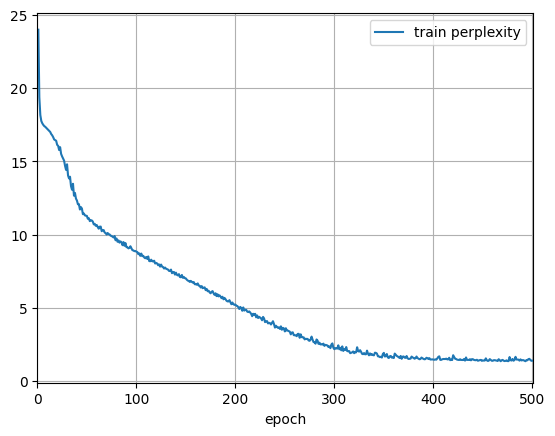

In [5]:
ml.train(num_epochs=500)  # 训练

In [6]:
ml.test()

2025-05-24 14:54:28,884 - INFO: test acc 0.894


In [7]:
ml.predict('time traveller ')

time traveller fore wers llons in asmive in a say i it one ove th
